In [1]:
import pandas as pd
import sqlite3
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from sklearn.preprocessing import MinMaxScaler
import os

demoStart = '2018-08-01'
demoEnd = '2019-09-29'


In [2]:
path = os.path.realpath('../MLB_app_react/mlbapp/')
filename = 'mlb.db'
db_path = os.path.join(path, filename)

In [3]:
park_factors = {
    'Tampa Bay Rays' : .96,
    'Boston Red Sox' : 1.05,
    'Miami Marlins' : .91,
    'Chicago Cubs' : 1.01, 
    'Kansas City Royals' : 1.02,
    'Chicago White Sox' : .98,
    'Seattle Mariners' : .95,
    'Cleveland Indians' : 1.05,
    'Arizona Diamondbacks' : 1.03,
    'Colorado Rockies' : 1.15,
    'Texas Rangers' : 1.11, 
    'Houston Astros' : .94, 
    'Oakland Athletics' : .96,
    'Los Angeles Angels' : .97,
    'San Diego Padres' : .98, 
    'Milwaukee Brewers' : 1.01,
    'Baltimore Orioles' : .99, 
    'Minnesota Twins' : 1.02,
    'Toronto Blue Jays' : 1.01,
    'New York Yankees' : 1.03,
    'Atlanta Braves' : 1.02, 
    'Philadelphia Phillies' : .99,
    'Detroit Tigers' : 1.02,
    'Pittsburgh Pirates' : .97,
    'Los Angeles Dodgers' : .94,
    'San Francisco Giants' : .98,
    'New York Mets' : .93,
    'St. Louis Cardinals' : .96,
    'Cincinnati Reds' : 1.02,
    'Washington Nationals' : 1.02
}


In [4]:
def get_historic_games(fromDate='2019-07-01'):
    
    q = '''
    SELECT 
        date, calendarEventID, 
        home_team_name,  p_home_id, home_score,  home_isWinner,
        away_team_name,  p_away_id, away_score,
        a_pitcher.person_fullName as p_away_name,
        h_pitcher.person_fullName as p_home_name
    FROM
        v_reg_games
        INNER JOIN rosters as a_pitcher on a_pitcher.person_id = v_reg_games.p_away_id
        INNER JOIN rosters as h_pitcher on h_pitcher.person_id = v_reg_games.p_home_id
    WHERE 
        --season = '2019'
        v_reg_games.date > '{fromDate}'
        order by calendarEventID, date
    '''.format(fromDate=fromDate)

    conn = sqlite3.connect(db_path)
    return pd.read_sql(q, conn)

df = get_historic_games(fromDate= demoStart)
df['Park_factor'] = df['home_team_name'].map(park_factors)

df.date = pd.to_datetime(df.date).dt.date


print(df.shape)

(2357, 12)


In [5]:
def calc_leauge_wOBA():
    q="""
    SELECT
        ((ifnull(sum(result_event_Walk),0) *0.690
        + ifnull(sum(result_event_Single),0) * 0.880
        + ifnull(sum(result_event_Double),0) * 1.247
        + ifnull(sum(result_event_Triple),0) * 1.578
        + ifnull(sum(result_event_Home_Run),0)  * 2.031
        + ifnull(sum(result_event_Hit_By_Pitch) ,0) * 0.720) /  
        (
        count(matchup_batter_id)
        + ifnull(sum(result_event_Walk),0 )
        + ifnull(sum(result_event_Sac_Fly),0 )
        + ifnull(sum(result_event_Sac_Bunt), 0) 
        - ifnull(sum(result_event_Intent_Walk),0)
        )) as wOBA,
        count(matchup_batSide_code) as PA
    FROM
        at_bats
        INNER JOIN v_reg_games as games on games.calendarEventID = at_bats.calendarEventID
        WHERE games.season = '2019'
    """
    

    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute(q)
    return c.fetchone()


def calc_leauge_avg_runs_PA():
    q="""
    SELECT 
        sum(runs) / sum(PA) as avg_runs_pr_pa
        FROM(
    SELECT
        games.calendarEventID,
        games.home_score + games.away_score as runs,
        count(matchup_batSide_code) as PA
    FROM 
        v_reg_games as games 
        INNER JOIN at_bats on at_bats.calendarEventID = games.calendarEventID
    WHERE games.season = '2019' 
    GROUP by games.calendarEventID)
    """
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute(q)
    return c.fetchone()[0]


In [6]:
df['league_wOBA'], df['leauge_PA'] = calc_leauge_wOBA()
df['leauge_avg_runs_pr_pa'] = calc_leauge_avg_runs_PA()
df['leauge_wOBA_scale'] = 1.226
print(df.shape)

(2357, 16)


In [7]:
def win_pct(team, homeGame, toDate):
    
    if homeGame:
        h_a = 'home'
    else:
        h_a = 'away'
    
    q="""
    SELECT
        ifnull(sum({h_a}_isWinner)*1.0 / count(calendarEventID),0.0) as win_pct,
        ifnull(avg({h_a}_score),0.0) as mean_runs
    FROM(
    SELECT *
    FROM
        v_reg_games
    WHERE
        {h_a}_team_name = '{team}'
        --AND season = '2019'
        AND date < '{toDate}'
        order by date desc
        limit (20))
        """.format(h_a = h_a, team=team, toDate=toDate)
    
    
    
    
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute(q)
    
    val = c.fetchone()
    
    return val
    

In [8]:
#### remember to add parks factor to away teams
df['H_win_pct'], df['H_mean_runs'] = zip(*df.apply(lambda x : win_pct(team=x['home_team_name'], 
                                                      homeGame=True,
                                                      toDate=x['date']),axis=1))


df['A_win_pct'], df['A_mean_runs'] = zip(*df.apply(lambda x : win_pct(team=x['away_team_name'],
                                                      homeGame=False,
                                                      toDate=x['date']),axis=1))

df.A_mean_runs = df.A_mean_runs * df.Park_factor

In [9]:
pred_cols =['H_win_pct','H_mean_runs', 'A_win_pct', 'A_mean_runs']

In [10]:
def matchup_win_pct(homeTeam, awayTeam, toDate):
    q="""SELECT
            ifnull(sum(home_isWinner)*1.0 / count(calendarEventID),0.0) as H_win_pct ,
            ifnull(sum(away_isWinner)*1.0 / count(calendarEventID),0.0)as A_win_pct ,
            ifnull(avg(home_score),0.0) as H_score,
            ifnull(avg(away_score),0.0) as A_score
         FROM (
         SELECT *
         FROM
            v_reg_games
         WHERE
            home_team_name = '{homeTeam}'
            AND away_team_name = '{awayTeam}'
            --AND season = '2019'
            AND date < '{toDate}'
            order by date desc
            limit (5))""".format(homeTeam=homeTeam, awayTeam=awayTeam, toDate=toDate)
    
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute(q)
    return c.fetchone()

In [11]:
df['H_win_pct_MUP'], df['A_win_pct_MUP'],df['H_mean_runs_MUP'],df['A_mean_runs_MUP'] = zip(*df.apply(
    lambda x : matchup_win_pct(homeTeam=x['home_team_name'],
                               awayTeam=x['away_team_name'],
                               toDate=x['date']), axis=1))


In [12]:
pred_cols.extend(['H_win_pct_MUP','A_win_pct_MUP','H_mean_runs_MUP','A_mean_runs_MUP'])

In [13]:
def calc_wOBA(num_games, toDate, team, home):
    
    home_away = ''
    if home:
        home_away = 'home'
    else:
        home_away = 'away'
        
    q="""SELECT
            ifnull((sum(BB) *0.690
            + sum(Single) * 0.880
            + sum(Double) * 1.247
            + sum(Triple) * 1.578
            + sum(HR)  * 2.031
            + sum(HBP) * 0.720) 
            /  
            (sum(PA)
            + sum(BB)
            + sum(Sac_Fly)
            + sum(Sac_Bunt) 
            - sum(IBB) ), 0.0) as wOBA,
            ifnull(sum(PA),0.0) as PA
            --sum(HR) / (sum(PA) - (sum(BB) + sum(HBP) + sum(IBB) + sum(Sac_Fly) + sum(Sac_Bunt))) as HR_K_ratio,
            --(sum(HR) + sum(Double) + sum(Triple)) / 
            --(sum(PA) - (sum(BB) + sum(HBP) + sum(IBB) + sum(Sac_Fly) + sum(Sac_Bunt))) as HH_K_ratio
                
        FROM(
            SELECT
                  ifnull(sum(result_event_Walk),0.0)*1.0 as BB,
                  ifnull(sum(result_event_Single),0.0)*1.0 as Single,
                  ifnull(sum(result_event_Double),0.0)*1.0 as Double,
                  ifnull(sum(result_event_Triple),0.0)*1.0 as Triple,
                  ifnull(sum(result_event_Home_Run),0.0)*1.0 as HR,
                  ifnull(sum(result_event_Hit_By_Pitch) ,0.0)*1.0 as HBP,
                  ifnull(sum(result_event_Sac_Fly), 0.0)*1.0 as Sac_Fly,
                  ifnull(sum(result_event_Sac_Bunt), 0.0)*1.0 as Sac_Bunt,
                  ifnull(sum(result_event_Intent_Walk),0.0)*1.0 as IBB,
                  count(matchup_batSide_code) as PA
            FROM
                at_bats
                INNER JOIN v_reg_games as games on games.calendarEventID = at_bats.calendarEventID
                INNER JOIN rosters as batters on batters.person_id = at_bats.matchup_batter_id
                INNER JOIN teams on teams.id = batters.team_id
            WHERE games.date < '{toDate}'
                AND teams.name = '{team}'
                AND games.{home_away}_team_name = '{team}'
                GROUP by games.calendarEventID
                ORDER by games.date DESC 
                LIMIT {num_games}
                )""".format(num_games=num_games, toDate=toDate, team=team, home_away=home_away)
    
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute(q)
    return c.fetchone()

In [14]:
df['H_wOBA_20'], df['H_PA_20']= zip(*df.apply(lambda x : calc_wOBA(toDate=x['date'],
                                                                         team=x['home_team_name'],
                                                                         num_games=20.0, home=True),axis=1))

df['H_wRC'] = (((df.H_wOBA_20 - df.league_wOBA)/df.leauge_wOBA_scale)+df.leauge_avg_runs_pr_pa)




df['A_wOBA_20'], df['A_PA_20']= zip(*df.apply(lambda x : calc_wOBA(toDate=x['date'],
                                                                         team=x['away_team_name'],
                                                                         num_games=20.0, home=False),axis=1))

df['A_wRC'] = (((df.A_wOBA_20 - df.league_wOBA)/df.leauge_wOBA_scale)+df.leauge_avg_runs_pr_pa)



df.drop(columns=['H_wOBA_20','H_PA_20', 'A_wOBA_20', 'A_PA_20'], inplace=True)

df.A_wRC = df.A_wRC * df.Park_factor

In [15]:
pred_cols.extend(['A_wRC', 'H_wRC'])

In [16]:
def matchup_wOBA(homeGame, homeTeam, awayTeam, toDate):
    
    if homeGame:
        team = homeTeam
        home_away = 'home'
    else:
        team = awayTeam
        home_away = 'away'
    
    q="""SELECT
            ifnull((sum(BB) *0.690
            + sum(Single) * 0.880
            + sum(Double) * 1.247
            + sum(Triple) * 1.578
            + sum(HR)  * 2.031
            + sum(HBP) * 0.720) 
            /  
            (sum(PA)
            + sum(BB)
            + sum(Sac_Fly)
            + sum(Sac_Bunt) 
            - sum(IBB) ),0.0) as wOBA,
            ifnull(sum(PA), 0.0) as PA
            
            FROM(
            SELECT
                  ifnull(sum(result_event_Walk),0)*1.0 as BB,
                  ifnull(sum(result_event_Single),0)*1.0 as Single,
                  ifnull(sum(result_event_Double),0)*1.0 as Double,
                  ifnull(sum(result_event_Triple),0)*1.0 as Triple,
                  ifnull(sum(result_event_Home_Run),0)*1.0  as HR,
                  ifnull(sum(result_event_Hit_By_Pitch),0)*1.0 as HBP,
                  ifnull(sum(result_event_Sac_Fly),0)*1.0 as Sac_Fly,
                  ifnull(sum(result_event_Sac_Bunt), 0)*1.0 as Sac_Bunt,
                  ifnull(sum(result_event_Intent_Walk),0)*1.0 as IBB,
                  count(matchup_batSide_code) as PA
            FROM
                at_bats
                INNER JOIN v_reg_games as games on games.calendarEventID = at_bats.calendarEventID
                INNER JOIN rosters as batters on batters.person_id = at_bats.matchup_batter_id
                INNER JOIN teams on teams.id = batters.team_id
                WHERE games.date < '{toDate}'
                AND teams.name = '{team}'
                AND games.home_team_name = '{homeTeam}'
                AND games.away_team_name = '{awayTeam}'
                --AND games.season = '2019'
                AND seriesDescription = 'Regular Season'
                GROUP by  games.calendarEventID
                ORDER by games.date DESC  
                LIMIT (5)
                )""".format(toDate=toDate, team=team, homeTeam=homeTeam, awayTeam=awayTeam,home_away=home_away )
    
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute(q)
    return c.fetchone()

In [17]:
df['H_matchup_wOBA'], df['H_matchup_pa'] = zip(*df.apply(lambda x : matchup_wOBA(toDate=x['date'],
                                                               homeGame = True,
                                                               homeTeam= x['home_team_name'],
                                                               awayTeam = x['away_team_name']),axis=1))

df['H_wRC_MUP'] = (((df.H_matchup_wOBA - df.league_wOBA)/df.leauge_wOBA_scale)+df.leauge_avg_runs_pr_pa)


df['A_matchup_wOBA'], df['A_matchup_pa'] = zip(*df.apply(lambda x : matchup_wOBA(toDate=x['date'],
                                                               homeGame = False,
                                                               homeTeam= x['home_team_name'],
                                                               awayTeam = x['away_team_name']),axis=1))

df['A_wRC_MUP'] = (((df.A_matchup_wOBA - df.league_wOBA)/df.leauge_wOBA_scale)+df.leauge_avg_runs_pr_pa)


df.drop(columns=['H_matchup_wOBA', 'A_matchup_wOBA','H_matchup_pa', 'A_matchup_pa'], inplace=True)


In [18]:
pred_cols.extend(['H_wRC_MUP', 'A_wRC_MUP'])

In [19]:
def cal_H_A_FIP(team, toDate, home, n_games=20):
    if home:
        home_away = 'home_team_name'
    else:
        home_away = 'away_team_name'
        
    q="""
    SELECT 
        ((sum(HRs) *13 +(sum(BB) + sum(HBP)) * 3 - (sum(K) *2)) / sum(IP)) + 3.161 AS FIP
    FROM(
        SELECT 
            ifnull(count(DISTINCT about_inning), 0.0) AS innings_pitched,
            ifnull(sum(result_event_Home_Run), 0.0) AS HRs,
            ifnull(sum(result_event_Walk), 0.0)AS BB,
            ifnull(sum(result_event_Hit_By_Pitch), 0.0) AS HBP,
            ifnull(sum(result_event_Strikeout), 0.0) AS K,
            ifnull(count(matchup_batSide_code), 0.0) AS PA,

            -- Innings pitched calc:
            (
                (
                sum(result_eventType like '%out%') +
                sum(result_eventType like '%stealing%') +
                sum(result_eventType like '%choice%') +
                sum(result_eventType like '%pickoff%') 
                )+
                sum(result_eventType like '%double_play%') * 2.0 +
                sum(result_eventType like '%triple_play%') * 3.0
            ) / 3.0 as IP
            ------
        FROM 
           at_bats
           INNER JOIN v_reg_games as games ON games.calendarEventID = at_bats.calendarEventID
           INNER JOIN rosters as p_r on p_r.person_id = at_bats.matchup_pitcher_id
           INNER JOIN teams as p_team on p_team.id = p_r.team_id
        WHERE games.date < '{toDate}'
           AND p_team.name = '{team}' 
           AND {home_away} = '{team}'
           --AND games.season = '2019'
    GROUP BY games.calendarEventID
    ORDER BY games.date DESC
    LIMIT {n_games}
    )""".format(home_away=home_away, team=team, toDate=toDate, n_games=n_games)
    
    
    #print(q)
    
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute(q)
    return c.fetchone()[0]
    

In [20]:
df['H_FIP'] = df.apply(lambda x : cal_H_A_FIP(team= x['home_team_name'],
                                                 toDate= x['date'],
                                                 home=True), axis=1)

df['A_FIP'] = df.apply(lambda x : cal_H_A_FIP(team= x['away_team_name'],
                                                 toDate= x['date'],
                                                 home=False), axis=1)

df.A_FIP = df.A_FIP*df.Park_factor

In [21]:
pred_cols.extend(['H_FIP', 'A_FIP'])

In [22]:
def matchup_FIP(homeGame, homeTeam, awayTeam, toDate):
    
    if homeGame:
        batting_team = awayTeam 
    else:
        batting_team = homeTeam
    
    q="""
    SELECT 
        ifnull(((sum(HRs) *13 +(sum(BB) + sum(HBP)) * 3 - (sum(K) *2)) / sum(IP)),0.0) + 3.161 AS FIP
    FROM(
        SELECT 
            ifnull(sum(result_event_Home_Run), 0) AS HRs,
            ifnull(sum(result_event_Walk), 0)AS BB,
            ifnull(sum(result_event_Hit_By_Pitch), 0) AS HBP,
            ifnull(sum(result_event_Strikeout), 0) AS K,
            count(matchup_batSide_code) AS PA,
            batters.person_fullName,
            at_bats.calendarEventID,
            
            -- Innings pitched calc:
            (
                (
                sum(result_eventType like '%out%') +
                sum(result_eventType like '%stealing%') +
                sum(result_eventType like '%choice%') +
                sum(result_eventType like '%pickoff%') 
                )+
                sum(result_eventType like '%double_play%') * 2.0 +
                sum(result_eventType like '%triple_play%') * 3.0
            ) / 3.0 as IP
            
            FROM
                at_bats
                INNER JOIN v_reg_games as games on games.calendarEventID = at_bats.calendarEventID
                INNER JOIN rosters as batters on batters.person_id = at_bats.matchup_batter_id
                INNER JOIN teams  as batting_team on batting_team.id = batters.team_id
                WHERE games.date < '{toDate}'
                AND batting_team.name = '{batting_team}'
                AND games.home_team_name = '{homeTeam}'
                AND games.away_team_name = '{awayTeam}'
                --AND games.season = '2019'
                GROUP by  games.calendarEventID
                ORDER by games.date DESC
                LIMIT(5)
                )""".format(toDate=toDate, batting_team=batting_team, homeTeam=homeTeam, awayTeam=awayTeam )
    

    
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute(q)
    return c.fetchone()[0]

In [23]:
df['H_FIP_MUP'] = df.apply(lambda x : matchup_FIP(homeGame=True, 
                                                      homeTeam = x['home_team_name'],
                                                      awayTeam=x['away_team_name'],
                                                     toDate=x['date']), axis=1)

df['A_FIP_MUP'] = df.apply(lambda x : matchup_FIP(homeGame=False, 
                                                      homeTeam = x['home_team_name'],
                                                      awayTeam=x['away_team_name'],
                                                     toDate=x['date']), axis=1)

In [24]:
pred_cols.extend(['H_FIP_MUP', 'A_FIP_MUP'])

In [25]:
def FIP_startingPitcher(pitcher_id, toDate, num_games, homeGame):
    if homeGame:
        halfinning = 'top'
        home_away_pitcher = 'p_home_id'
    else:
        halfinning = 'bottom'
        home_away_pitcher = 'p_away_id'
        
    q = """
    SELECT
        ifnull(((sum(HRs) *13 +(sum(BB) + sum(HBP)) * 3 - (sum(K) *2)) / sum(IP)),0.0) + 3.161 AS FIP
        FROM(
        SELECT
        ifnull(sum(result_event_Home_Run), 0) AS HRs,
                    ifnull(sum(result_event_Walk), 0)AS BB,
                    ifnull(sum(result_event_Hit_By_Pitch), 0) AS HBP,
                    ifnull(sum(result_event_Strikeout), 0) AS K,
                    count(matchup_batSide_code) AS PA,
                    count(DISTINCT about_inning) as IP
        FROM
        at_bats
        WHERE calendarEventID in(
        SELECT calendarEventID FROM games WHERE {home_away_pitcher} = '{pitcher_id}'
        AND date < '{toDate}'
        GROUP by date
        order by date DESC
        limit ({num_games})
        )
        and about_halfInning='{halfinning}'
        GROUP by date
        )""".format(pitcher_id=pitcher_id,toDate=toDate, num_games=num_games,
                    halfinning=halfinning, home_away_pitcher=home_away_pitcher )
    
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute(q)
    FIP = c.fetchone()[0]
    #print(f'query: {q} FIP: {FIP}')
    return FIP

In [26]:
df['H_FIP_SP'] = df.apply(lambda x : FIP_startingPitcher(pitcher_id=x['p_home_id'],
                                                         toDate=x['date'],
                                                         num_games=10,
                                                         homeGame=True,
                                                         ), axis=1)

df['A_FIP_SP'] = df.apply(lambda x : FIP_startingPitcher(pitcher_id=x['p_away_id'],
                                                         toDate=x['date'],
                                                         num_games=10,
                                                         homeGame=False,
                                                         ), axis=1)



In [27]:
pred_cols.extend(['H_FIP_SP', 'A_FIP_SP'])

In [28]:
def log_data(data):
    return np.log1p(data)

In [29]:
df[pred_cols] = df[pred_cols].apply(lambda x : log_data(x))

In [30]:
scaler = MinMaxScaler()

df[pred_cols] = scaler.fit_transform(df[pred_cols])

In [31]:
df['win_pct_diff'] = df.H_win_pct - df.A_win_pct
df['win_pct_diff_mup'] = df.H_win_pct_MUP - df.A_win_pct_MUP

df['wRC_diff'] = df.H_wRC - df.A_wRC
df['wRC_diff_mup'] = df.H_wRC_MUP - df.A_wRC_MUP

df['FIP_diff'] = df.A_FIP - df.H_FIP
df['FIP_diff_mup'] = df.A_FIP_MUP - df.H_FIP_MUP

df['runs_diff'] = df.H_mean_runs - df.A_mean_runs
df['runs_diff_mup'] = df.H_mean_runs_MUP - df.A_mean_runs_MUP

df['FIP_SP_diff'] = df.A_FIP_SP - df.H_FIP_SP

In [32]:
df_valid = df.loc[df.date> dt.date(2019,8,30)]
df = df.drop(df_valid.index)

In [33]:
df.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

In [34]:
pred_cols = ['win_pct_diff', 'win_pct_diff_mup', 'wRC_diff',
             'wRC_diff_mup', 'FIP_diff', 'FIP_diff_mup',
            'runs_diff', 'runs_diff_mup', 'FIP_SP_diff']

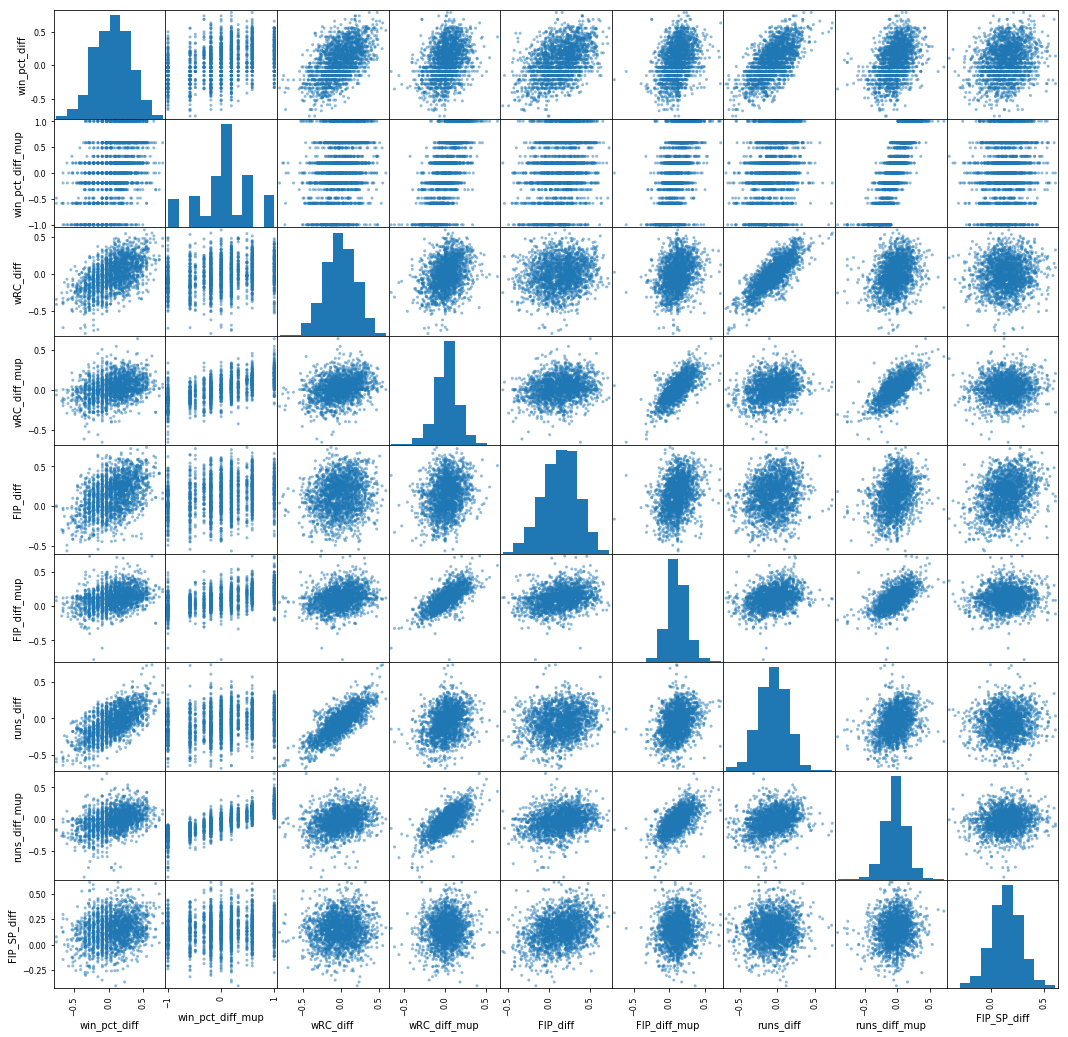

In [35]:
pd.plotting.scatter_matrix(df[pred_cols], figsize=(18,18))
plt.show()

In [36]:
for col in pred_cols:
    print(f'{col}: {pointbiserialr(df.home_isWinner,df[col])}')

win_pct_diff: PointbiserialrResult(correlation=0.13078435451754505, pvalue=4.834586745176427e-09)
win_pct_diff_mup: PointbiserialrResult(correlation=0.05657795370233362, pvalue=0.011633347440174312)
wRC_diff: PointbiserialrResult(correlation=0.06521386589799741, pvalue=0.0036263530476765525)
wRC_diff_mup: PointbiserialrResult(correlation=0.061691444839419796, pvalue=0.005931812639930292)
FIP_diff: PointbiserialrResult(correlation=0.12784615622250173, pvalue=1.0641283027850804e-08)
FIP_diff_mup: PointbiserialrResult(correlation=0.0877566084974517, pvalue=8.93226861700583e-05)
runs_diff: PointbiserialrResult(correlation=0.08240371308480593, pvalue=0.00023499670026614085)
runs_diff_mup: PointbiserialrResult(correlation=0.08584199726505021, pvalue=0.00012705180950139686)
FIP_SP_diff: PointbiserialrResult(correlation=0.08073625926018829, pvalue=0.00031407377788034206)


In [37]:
X = df[pred_cols]
y = df.home_isWinner

X_v = df_valid[pred_cols]
y_v = df_valid.home_isWinner

In [38]:
#from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [40]:
cv = StratifiedKFold(n_splits=10, random_state=10)
pipe = Pipeline(steps=([('XG' , XGBClassifier())]))

paramGrid = {
            'XG__max_depth' : [3, 4,],
            'XG__n_estimators' : [500],
            'XG__subsample' : [.5, .8, .9],
            'XG__colsample_bytree' : [.4, .5, .6],
            'XG__min_child_weight' : [3, 4, 6],
            'XG__learning_rate' : [.001, .005],
            'XG__gamma' : [2, 3, 5],
            'XG__random_state' : [42],
            'XG__base_score': [np.mean(y_train)],
            'XG__objective':['binary:logistic']}

gridsearch = GridSearchCV(pipe, paramGrid, cv=cv, verbose=True,  n_jobs=-1, return_train_score=True)
gridsearch.fit(X_train, y_train)
print(gridsearch.best_params_)
model = gridsearch.best_estimator_

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  2.7min finished


{'XG__base_score': 0.5251690458302029, 'XG__colsample_bytree': 0.4, 'XG__gamma': 2, 'XG__learning_rate': 0.005, 'XG__max_depth': 4, 'XG__min_child_weight': 6, 'XG__n_estimators': 500, 'XG__objective': 'binary:logistic', 'XG__random_state': 42, 'XG__subsample': 0.8}


In [41]:
gridsearch.best_score_

0.5837716003005259

In [42]:
df_results = pd.DataFrame.from_dict(gridsearch.cv_results_)

In [44]:
# train score
bin_preds = model.predict(X_train)
prob_preds = model.predict_proba(X_train)
print(accuracy_score(y_train, bin_preds))
print (confusion_matrix(y_train, bin_preds))
print(roc_auc_score(y_train, prob_preds[:,1]))

0.7220135236664162
[[375 257]
 [113 586]]
0.8106653265967657


In [45]:
# test score
bin_preds = model.predict(X_test)
prob_preds = model.predict_proba(X_test)
print(accuracy_score(y_test, bin_preds))
print (confusion_matrix(y_test, bin_preds))
print(roc_auc_score(y_test, prob_preds[:,1]))

0.5418569254185692
[[130 173]
 [128 226]]
0.5712181387630288


In [75]:
best_model = model.named_steps['XG'].fit(X= X_train, 
                                         y= y_train, eval_set=[(X_train, y_train),(X_test, y_test)],
                                         eval_metric = ['logloss'],
                                         early_stopping_rounds = 30,verbose=25)

[0]	validation_0-logloss:0.691578	validation_1-logloss:0.690413
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 30 rounds.
[25]	validation_0-logloss:0.684702	validation_1-logloss:0.68833
[50]	validation_0-logloss:0.678348	validation_1-logloss:0.686809
[75]	validation_0-logloss:0.672625	validation_1-logloss:0.685908
[100]	validation_0-logloss:0.667063	validation_1-logloss:0.685209
[125]	validation_0-logloss:0.661938	validation_1-logloss:0.684246
[150]	validation_0-logloss:0.657197	validation_1-logloss:0.683867
[175]	validation_0-logloss:0.65275	validation_1-logloss:0.683738
[200]	validation_0-logloss:0.648631	validation_1-logloss:0.683368
[225]	validation_0-logloss:0.644757	validation_1-logloss:0.683016
[250]	validation_0-logloss:0.641039	validation_1-logloss:0.683078
[275]	validation_0-logloss:0.637579	validation_1-logloss:0.682876
[300]	validation_0-logloss:0.634374	validation_1-l

In [76]:
# train score
bin_preds = best_model.predict(X_train)
prob_preds = best_model.predict_proba(X_train)
print(accuracy_score(y_train, bin_preds))
print (confusion_matrix(y_train, bin_preds))
print(roc_auc_score(y_train, prob_preds[:,1]))

0.6994740796393689
[[337 295]
 [105 594]]
0.7890895221020989


In [77]:
# test score
bin_preds = best_model.predict(X_test)
prob_preds = best_model.predict_proba(X_test)
print(accuracy_score(y_test, bin_preds))
print (confusion_matrix(y_test, bin_preds))
print(roc_auc_score(y_test, prob_preds[:,1]))

0.54337899543379
[[123 180]
 [120 234]]
0.5705562081631892


In [78]:
valid_bin_preds = best_model.predict(X_v)
valid_prob_preds = best_model.predict_proba(X_v)
print(f'Accuracy_score: {accuracy_score(y_v, valid_bin_preds)} \n')
print(f'Roc_auc_score: {roc_auc_score(y_v, valid_prob_preds[:,1])}\n')
print(confusion_matrix(y_v, valid_bin_preds))

Accuracy_score: 0.6124661246612466 

Roc_auc_score: 0.6481590574374079

[[ 88  87]
 [ 56 138]]


In [79]:
import joblib
joblib.dump(model, "best_model.joblib.dat")
#best_model = joblib.load("best_model.joblib.dat")

['best_model.joblib.dat']

In [80]:
values = df_valid[pred_cols + ['home_isWinner']]
n_iterations = 1000
n_size = int(len(values) * 0.50)

# run bootstrap
stats = []
roc_stats = []
for i in range(n_iterations):
    data = resample(values, n_samples=n_size)

    bin_preds = model.predict(data[pred_cols])
    prob_preds = model.predict_proba(data[pred_cols])

    acc_score = accuracy_score(data['home_isWinner'], bin_preds)
    roc_score = roc_auc_score(data['home_isWinner'], prob_preds[:,1])
    stats.append(acc_score)
    roc_stats.append(roc_score)


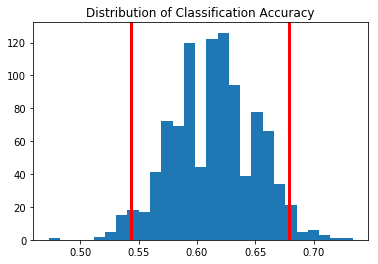

95.0 confidende interval 54.347826086956516 | 67.93478260869566


In [81]:
alpha = .95
p = ((1.0 - alpha) / 2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha + ((1.0 - alpha) / 2.0)) * 100
upper = min(1.0, np.percentile(stats, p))

# plot
plt.hist(stats, bins='auto')
plt.axvline(lower, color='red', lw=3)
#plt.text(lower, n_iterations // 4, 'Lower Bound', rotation=90)
plt.axvline(upper, color='red', lw=3)
#plt.text(upper, n_iterations // 4, 'Upper Bound', rotation=90)
plt.title('Distribution of Classification Accuracy')
plt.show()
print(f'{alpha*100} confidende interval {lower*100} | {upper*100}')

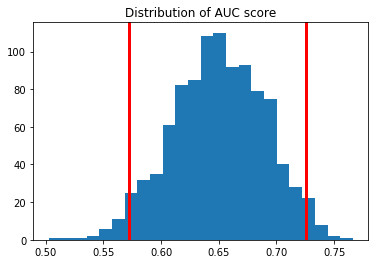

95.0 confidende interval 57.1970617285504 | 72.55297111742424


In [82]:
alpha = .95
p = ((1.0 - alpha) / 2.0) * 100
lower = max(0.0, np.percentile(roc_stats, p))
p = (alpha + ((1.0 - alpha) / 2.0)) * 100
upper = min(1.0, np.percentile(roc_stats, p))

# plot
plt.hist(roc_stats, bins='auto')
plt.axvline(lower, color='red', lw=3)
#plt.text(lower, n_iterations // 4, 'Lower Bound', rotation=90)
plt.axvline(upper, color='red', lw=3)
#plt.text(upper, n_iterations // 4, 'Upper Bound', rotation=90)
plt.title('Distribution of AUC score')
plt.show()
print(f'{alpha*100} confidende interval {lower*100} | {upper*100}')

<Figure size 1296x1296 with 0 Axes>

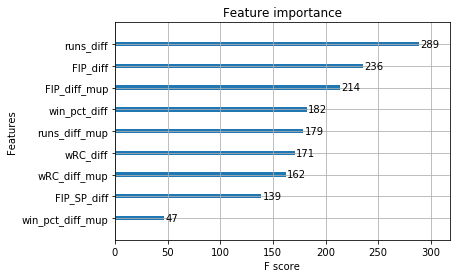

In [56]:
%matplotlib inline
from xgboost import plot_importance
plt.figure(figsize=(18,18))
plot_importance(best_model)

In [83]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_v)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_v.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


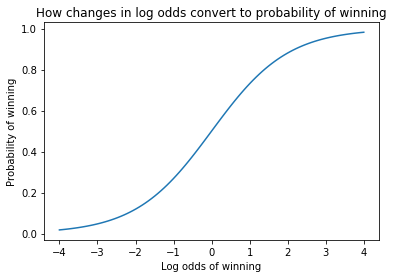

In [90]:
xs = np.linspace(-4,4,100)
plt.xlabel("Log odds of winning")
plt.ylabel("Probability of winning")
plt.title("How changes in log odds convert to probability of winning")
plt.plot(xs, 1/(1+np.exp(-xs)))
plt.show()

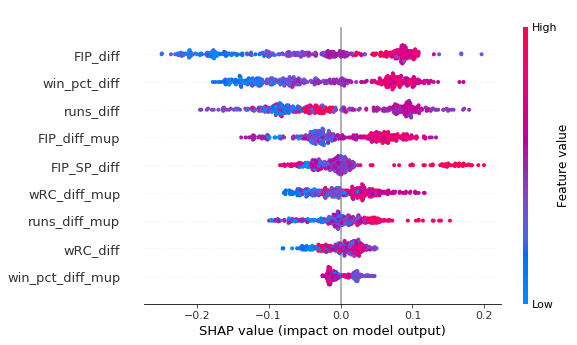

In [91]:
shap.summary_plot(shap_values, X_v) de

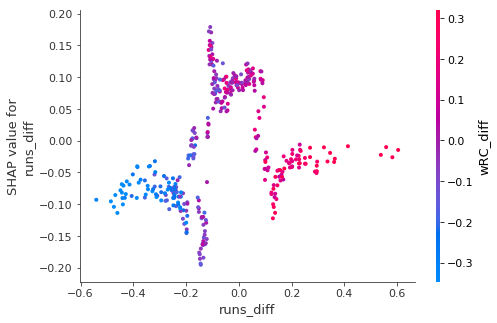

In [95]:
shap.dependence_plot("runs_diff", shap_values, X_v, interaction_index="wRC_diff")

In [97]:
cols = ['date', 'calendarEventID', 'home_team_name', 'p_home_name', 'home_score',
       'home_isWinner', 'away_team_name', 'p_away_name', 'away_score']
df_valid = df_valid[cols]

In [98]:
d = {'Predictions' : valid_bin_preds, 'Proba': valid_prob_preds[:, 1] }
preds = pd.DataFrame(data=d)
preds

,Predictions,Proba
0,0,0.386937
1,0,0.429916
2,0,0.492971
3,0,0.477405
4,1,0.517036
...,...,...
364,1,0.551932
365,1,0.563383
366,1,0.584690
367,1,0.605046


In [102]:
df_finished = pd.concat([df_valid, preds], axis=1)

In [103]:
conn = sqlite3.connect(db_path)

df_finished.to_sql('results',conn , if_exists='replace')